In [2]:
# # download and update library
!git clone https://github.com/Kemsekov/kemsekov_torch
!cd kemsekov_torch && git pull

fatal: destination path 'kemsekov_torch' already exists and is not an empty directory.
Already up to date.


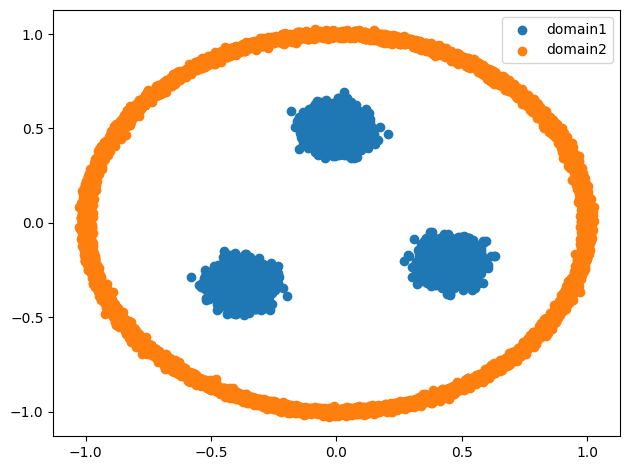

In [3]:
from matplotlib import pyplot as plt
import torch

size = 10000
X = torch.randint(0,3,(size,))*2
Y = torch.cos(X)+torch.randn_like(1.0*X)*0.1
X = torch.sin(X)+torch.randn_like(1.0*X)*0.1
domain1 = torch.stack([X,Y],-1)/2

n=2
X = torch.linspace(-torch.pi,torch.pi,size)
Y = torch.cos(X)
X = torch.sin(X)
domain2 = torch.stack([X,Y],-1)
domain2+=torch.randn_like(domain2)*0.01




# domain1=torch.randn_like(domain1)
# domain2=torch.randn_like(domain2)
# domain2[:,0]/=3
# domain2[:,1]/=2

# domain1[:,0]/=8
# domain1[:,1]/=3
# domain2[:,0]+=3

plt.scatter(*domain1.chunk(2,-1),label='domain1')
plt.scatter(*domain2.chunk(2,-1),label='domain2')
plt.tight_layout()
plt.legend()

In [4]:
import random
import numpy as np
from kemsekov_torch.train import split_dataset

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self,domain1,domain2,seed=1):
        self.ind = np.array(range(len(domain1)))
        np.random.seed(seed)
        np.random.shuffle(self.ind)
        
        self.d1 = domain1
        self.d2 = domain2
    def __getitem__(self, index):
        ind1=random.randint(0,len(self.d1)-1)
        
        d1,d2 = self.d1[ind1],self.d2[index]
        return d1,d2
    def __len__(self):
        return len(self.d1)
dataset = PairedDataset(domain1,domain2)
train_dataset,test_dataset,train_loader, test_loader = split_dataset(
    dataset,
    test_size=0.0,
    batch_size=64,
    num_workers=16
)

/home/vlad/Programs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train items 10000


In [5]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3,256), #x,y + time
            nn.LayerNorm(256),
            nn.ELU(),
            nn.Linear(256,256),
            nn.LayerNorm(256),
            nn.ELU(),
            nn.Linear(256,2),
        )
    def forward(self,x,t : torch.Tensor):
        if t.dim()==1:
            t = t[:,None]
        xt = torch.concat([x,t],-1)
        return self.model(xt)

In [ ]:
from kemsekov_torch.train import train
from kemsekov_torch.metrics import r2_score
from kemsekov_torch.flow_matching import FlowMatching

def scaled_mse(pred,target):
    tabs=target.detach().pow(2).mean(-1,keepdim=True)
    return (pred-target).pow(2).div(tabs).mean()

def mse(pred,target,scale=1):
    return (pred-target).pow(2).mul(scale).mean()

def same_dir_loss(batch_repeats, pred_dir):
    same_dir_loss = []
    same_dirs = pred_dir.chunk(batch_repeats,0)
    for i in range(batch_repeats):
        for b in range(i+1,batch_repeats):
            same_dir_loss.append(mse(same_dirs[i],same_dirs[b]))
    same_dir_loss=sum(same_dir_loss)/len(same_dir_loss)
    return same_dir_loss

num_epochs=20

fm = FlowMatching()

def compute_loss_and_metric(model,batch):
    d1,d2 = batch
    
    # d1_sample = sample_with_euler_integrator(model,d2,8,0,inverse=True)
    # d1=reflow_power*d1_sample+(1-reflow_power)*d1
    batch_repeats = 8
    
    d1=torch.concat([d1]*batch_repeats,0)
    d2=torch.concat([d2]*batch_repeats,0)
    
    pred_dir,true_dir,contrast,t = fm.contrastive_flow_matching_pair(model,d1,d2)
    
    # these directions must be the same
    # same_dir_loss_ = same_dir_loss(batch_repeats, pred_dir)
    
    # l2 prediction dir penalty
    # l2=pred_dir.pow(2).sum(-1).mean()*0.1
    loss = mse(pred_dir,true_dir)-0.05*mse(contrast,pred_dir)
    return loss,{
        'r2':r2_score(pred_dir,true_dir),
    }


m = Model()
optim = torch.optim.Adam(m.parameters(),1e-2)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader)//3)

train(
    m,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    'runs/flow-matching',
    save_on_metric_improve=['r2'],
    num_epochs=20,
    optimizer=optim,
    scheduler=sch,
    accelerate_args={
        'mixed_precision':'bf16'
    }
)

Total model parameters 0.07 M
Using device cuda


FileNotFoundError: Could not find shared object file for Transformer Engine torch lib.

In [ ]:
from kemsekov_torch.train import load_best_checkpoint
m = load_best_checkpoint(m,"runs/flow-matching").eval().cpu()

d1s = []
d2s = []
count = 0
for d1,d2 in train_loader:
    d1s.append(d1)
    d2s.append(d2)
    count+=1
    if count>4: break
d1 = torch.concat(d1s,0)
d2 = torch.concat(d2s,0)

In [ ]:
steps=64
churn_scale=0.00
d2_pred,paths = fm.sample(m,d1,steps,churn_scale=churn_scale,return_intermediates=True)
d1_pred,paths2 = fm.sample(m,d2,steps,churn_scale=churn_scale,inverse=True,return_intermediates=True)

plt.scatter(*d1.chunk(2,-1),label='d1')
plt.scatter(*d2.chunk(2,-1),label='d2')
plt.scatter(*d2_pred.chunk(2,-1),label='d2 pred')
plt.scatter(*d1_pred.chunk(2,-1),label='d1 pred')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from random import shuffle
plt.figure(figsize=(8,8))
paths_stack = torch.stack(paths,0).transpose(0,1)

plt.scatter(*paths_stack[:,0,:].chunk(2,-1),c='blue',label='start')
plt.scatter(*paths_stack[:,-1,:].chunk(2,-1),c='orange',label='end')

for path in paths_stack:
    start = path[0]
    end = path[-1]

    if random.randint(0,10)==0:
        plt.plot(*path.chunk(2,-1),c="gray")
plt.legend()